In [176]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt


In [172]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 20
batch_size = 64

train_data = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root='./data', train=False, transform =transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [192]:
class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(Encoder, self).__init__()

        self.activation_layer = nn.ReLU()
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=7, stride=2, padding=1),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=2, padding=1)
        ])
        
        self.bottle_neck_layers = nn.ModuleList([
            nn.Linear(64, 32),
            nn.Linear(32, 16),
            nn.Linear(16, latent_dim)
        ])


    
    def forward(self, x):
        for index in range(len(self.conv_layers)):
            x = self.conv_layers[index](x)
            x = self.activation_layer(x)
        
        x = x.view(-1, 64)

        for index in range(len(self.bottle_neck_layers)):
            x = self.bottle_neck_layers[index](x)
            x = self.activation_layer(x)
        
        return x


class Decoder(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(Decoder, self).__init__()
        self.activation_layer = nn.ReLU()
        self.output_activation = nn.Sigmoid()

        self.bottle_neck_layers = nn.ModuleList([
            nn.Linear(latent_dim, 16),
            nn.Linear(16, 32),
            nn.Linear(32, 64)
        ])     

        self.trans_conv_layers = nn.ModuleList([
            nn.ConvTranspose2d(64, 32, 7),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ConvTranspose2d(16, input_channels, 3, stride=2, padding=1, output_padding=1)
        ])

    
    def forward(self, x):

        for index in range(len(self.bottle_neck_layers)):
            x = self.bottle_neck_layers[index](x)
            x = self.activation_layer(x)
        
        x = x.view(-1, 64, 1, 1)

        for index in range(len(self.trans_conv_layers)-1):
            x = self.trans_conv_layers[index](x)
            x = self.activation_layer(x)
        
        x = self.trans_conv_layers[-1](x)
        x = self.output_activation(x)

        return x


class AutoEncoder(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(AutoEncoder, self).__init__()

        self.encoder = Encoder(1, 8)
        self.decoder = Decoder(1, 8)

    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x




In [199]:
model = AutoEncoder(1, 8).to(device)
##################################################################
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# ##################################################################

In [201]:
for epoch in range(num_epochs):
    for batch_num, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        output_pred = model(data)

        loss = criterion(output_pred, data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    print(f"Epoch : {epoch+1}, loss : {loss}")

        


Epoch : 1, loss : 0.019907522946596146
Epoch : 2, loss : 0.021519212052226067
Epoch : 3, loss : 0.024061178788542747
Epoch : 4, loss : 0.021891895681619644
Epoch : 5, loss : 0.022247163578867912
Epoch : 6, loss : 0.021902648732066154
Epoch : 7, loss : 0.021145790815353394
Epoch : 8, loss : 0.024303602054715157
Epoch : 9, loss : 0.02407398261129856
Epoch : 10, loss : 0.02154369279742241
Epoch : 11, loss : 0.02753884345293045
Epoch : 12, loss : 0.020372355356812477
Epoch : 13, loss : 0.024457573890686035
Epoch : 14, loss : 0.027642425149679184
Epoch : 15, loss : 0.02319193072617054
Epoch : 16, loss : 0.024124059826135635
Epoch : 17, loss : 0.02364731766283512
Epoch : 18, loss : 0.020589152351021767
Epoch : 19, loss : 0.020979978144168854
Epoch : 20, loss : 0.022950032725930214


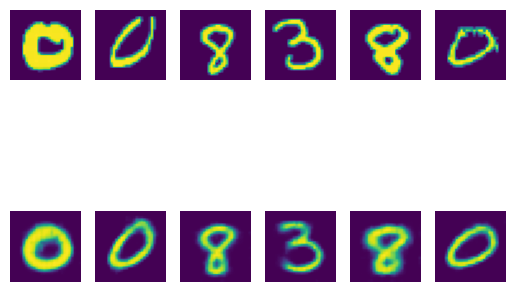

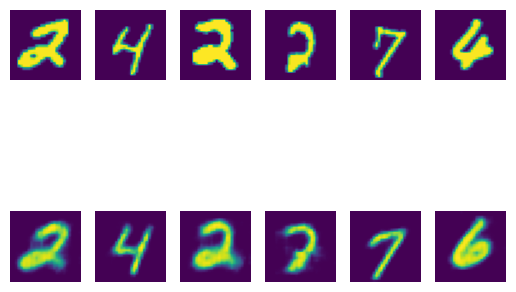

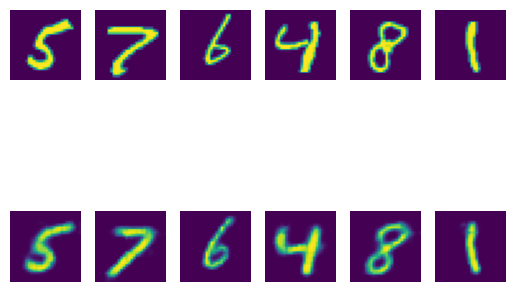

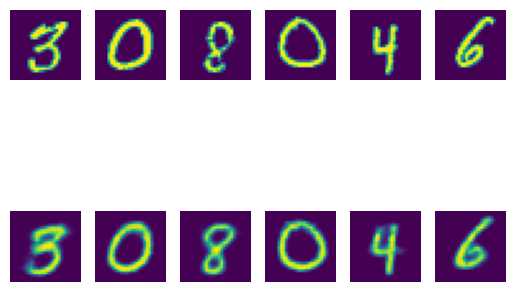

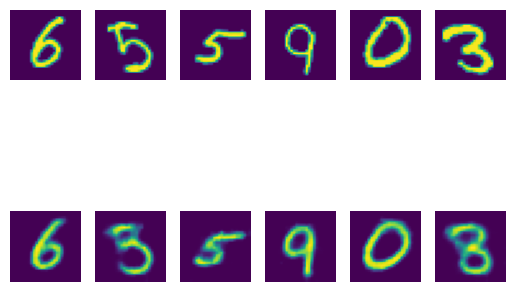

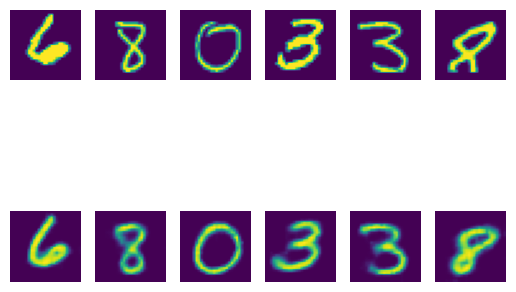

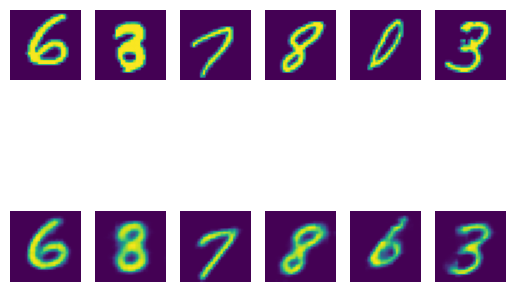

In [206]:
with torch.no_grad():
    for index, (data, label) in enumerate(test_loader):
        test_model = model.to('cpu')
        output_img = test_model(data)
        plt.figure()
        for img_index in range(6): 

            plt.subplot(2, 6 , img_index+1)
            plt.imshow(data[img_index].view(data.shape[-2], data.shape[-1], 1))
            plt.axis('off')
            plt.subplot(2, 6, img_index+1+6)
            plt.imshow(output_img[img_index].view(output_img.shape[-2], output_img.shape[-1], 1))
            plt.axis('off')
        if index>=6:
            break